In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, RocCurveDisplay
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

In [3]:
data = pd.read_csv("heart.csv")
print("Shape of the data:", data.shape)
data.head()



Shape of the data: (303, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [5]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
age,303.0,54.366337,9.082101,29.0,47.5,55.0,61.0,77.0
sex,303.0,0.683168,0.466011,0.0,0.0,1.0,1.0,1.0
cp,303.0,0.966997,1.032052,0.0,0.0,1.0,2.0,3.0
trestbps,303.0,131.623762,17.538143,94.0,120.0,130.0,140.0,200.0
chol,303.0,246.264026,51.830751,126.0,211.0,240.0,274.5,564.0
fbs,303.0,0.148515,0.356198,0.0,0.0,0.0,0.0,1.0
restecg,303.0,0.528053,0.525860,0.0,0.0,1.0,1.0,2.0
thalach,303.0,149.646865,22.905161,71.0,133.5,153.0,166.0,202.0
exang,303.0,0.326733,0.469794,0.0,0.0,0.0,1.0,1.0
oldpeak,303.0,1.039604,1.161075,0.0,0.0,0.8,1.6,6.2


In [6]:
data = data.rename(
    columns={
        "cp": "chest_pain_type",
        "trestbps": "resting_blood_pressure",
        "chol": "cholesterol",
        "fbs": "fasting_blood_sugar",
        "restecg": "resting_ecg",
        "thalach": "max_heart_rate_achieved",
        "exang": "exercise_induced_angina",
        "oldpeak": "st_depression",
        "slope": "st_slope",
        "ca": "num_major_vessels",
        "thal": "thalassemia",
    },
    errors="raise",
)

In [7]:
data.head()

,age,sex,chest_pain_type,resting_blood_pressure,cholesterol,fasting_blood_sugar,resting_ecg,max_heart_rate_achieved,exercise_induced_angina,st_depression,st_slope,num_major_vessels,thalassemia,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


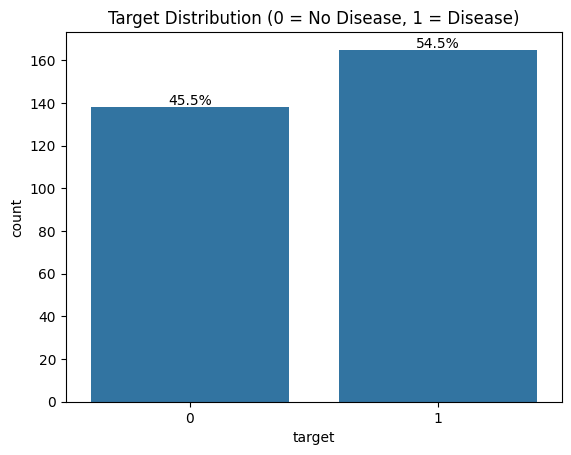

In [8]:
plt.figure()
ax = sns.countplot(x=data["target"])
plt.title("Target Distribution (0 = No Disease, 1 = Disease)")

total = len(data)
for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2,
        height + 1,
        f"{(height/total)*100:.1f}%",
        ha="center",
    )

plt.show()

In [9]:
numeric_features = [
    "age",
    "resting_blood_pressure",
    "cholesterol",
    "max_heart_rate_achieved",
    "st_depression",
]
categorical_features = [
    "sex",
    "chest_pain_type",
    "fasting_blood_sugar",
    "resting_ecg",
    "exercise_induced_angina",
    "st_slope",
    "num_major_vessels",
    "thalassemia",
]


In [10]:
data[categorical_features] = data[categorical_features].astype(int)

data[numeric_features + categorical_features].head()

,age,resting_blood_pressure,cholesterol,max_heart_rate_achieved,st_depression,sex,chest_pain_type,fasting_blood_sugar,resting_ecg,exercise_induced_angina,st_slope,num_major_vessels,thalassemia
0,63,145,233,150,2.3,1,3,1,0,0,0,0,1
1,37,130,250,187,3.5,1,2,0,1,0,0,0,2
2,41,130,204,172,1.4,0,1,0,0,0,2,0,2
3,56,120,236,178,0.8,1,1,0,1,0,2,0,2
4,57,120,354,163,0.6,0,0,0,1,1,2,0,2


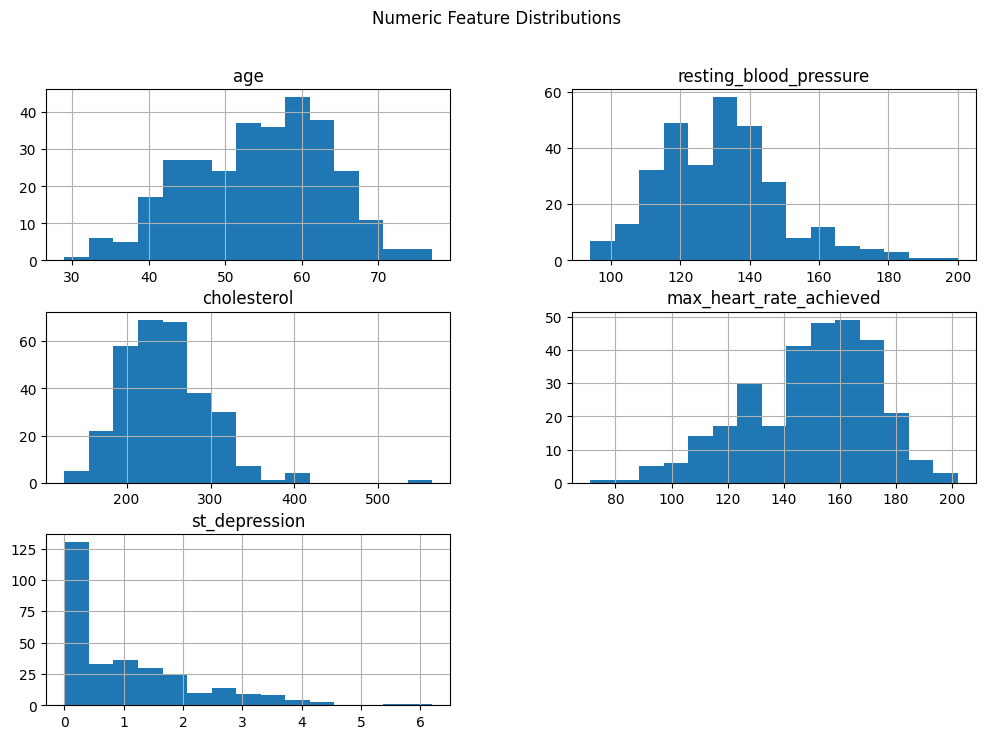

In [11]:
data[numeric_features].hist(bins=15, figsize=(12, 8))
plt.suptitle("Numeric Feature Distributions")
plt.show()

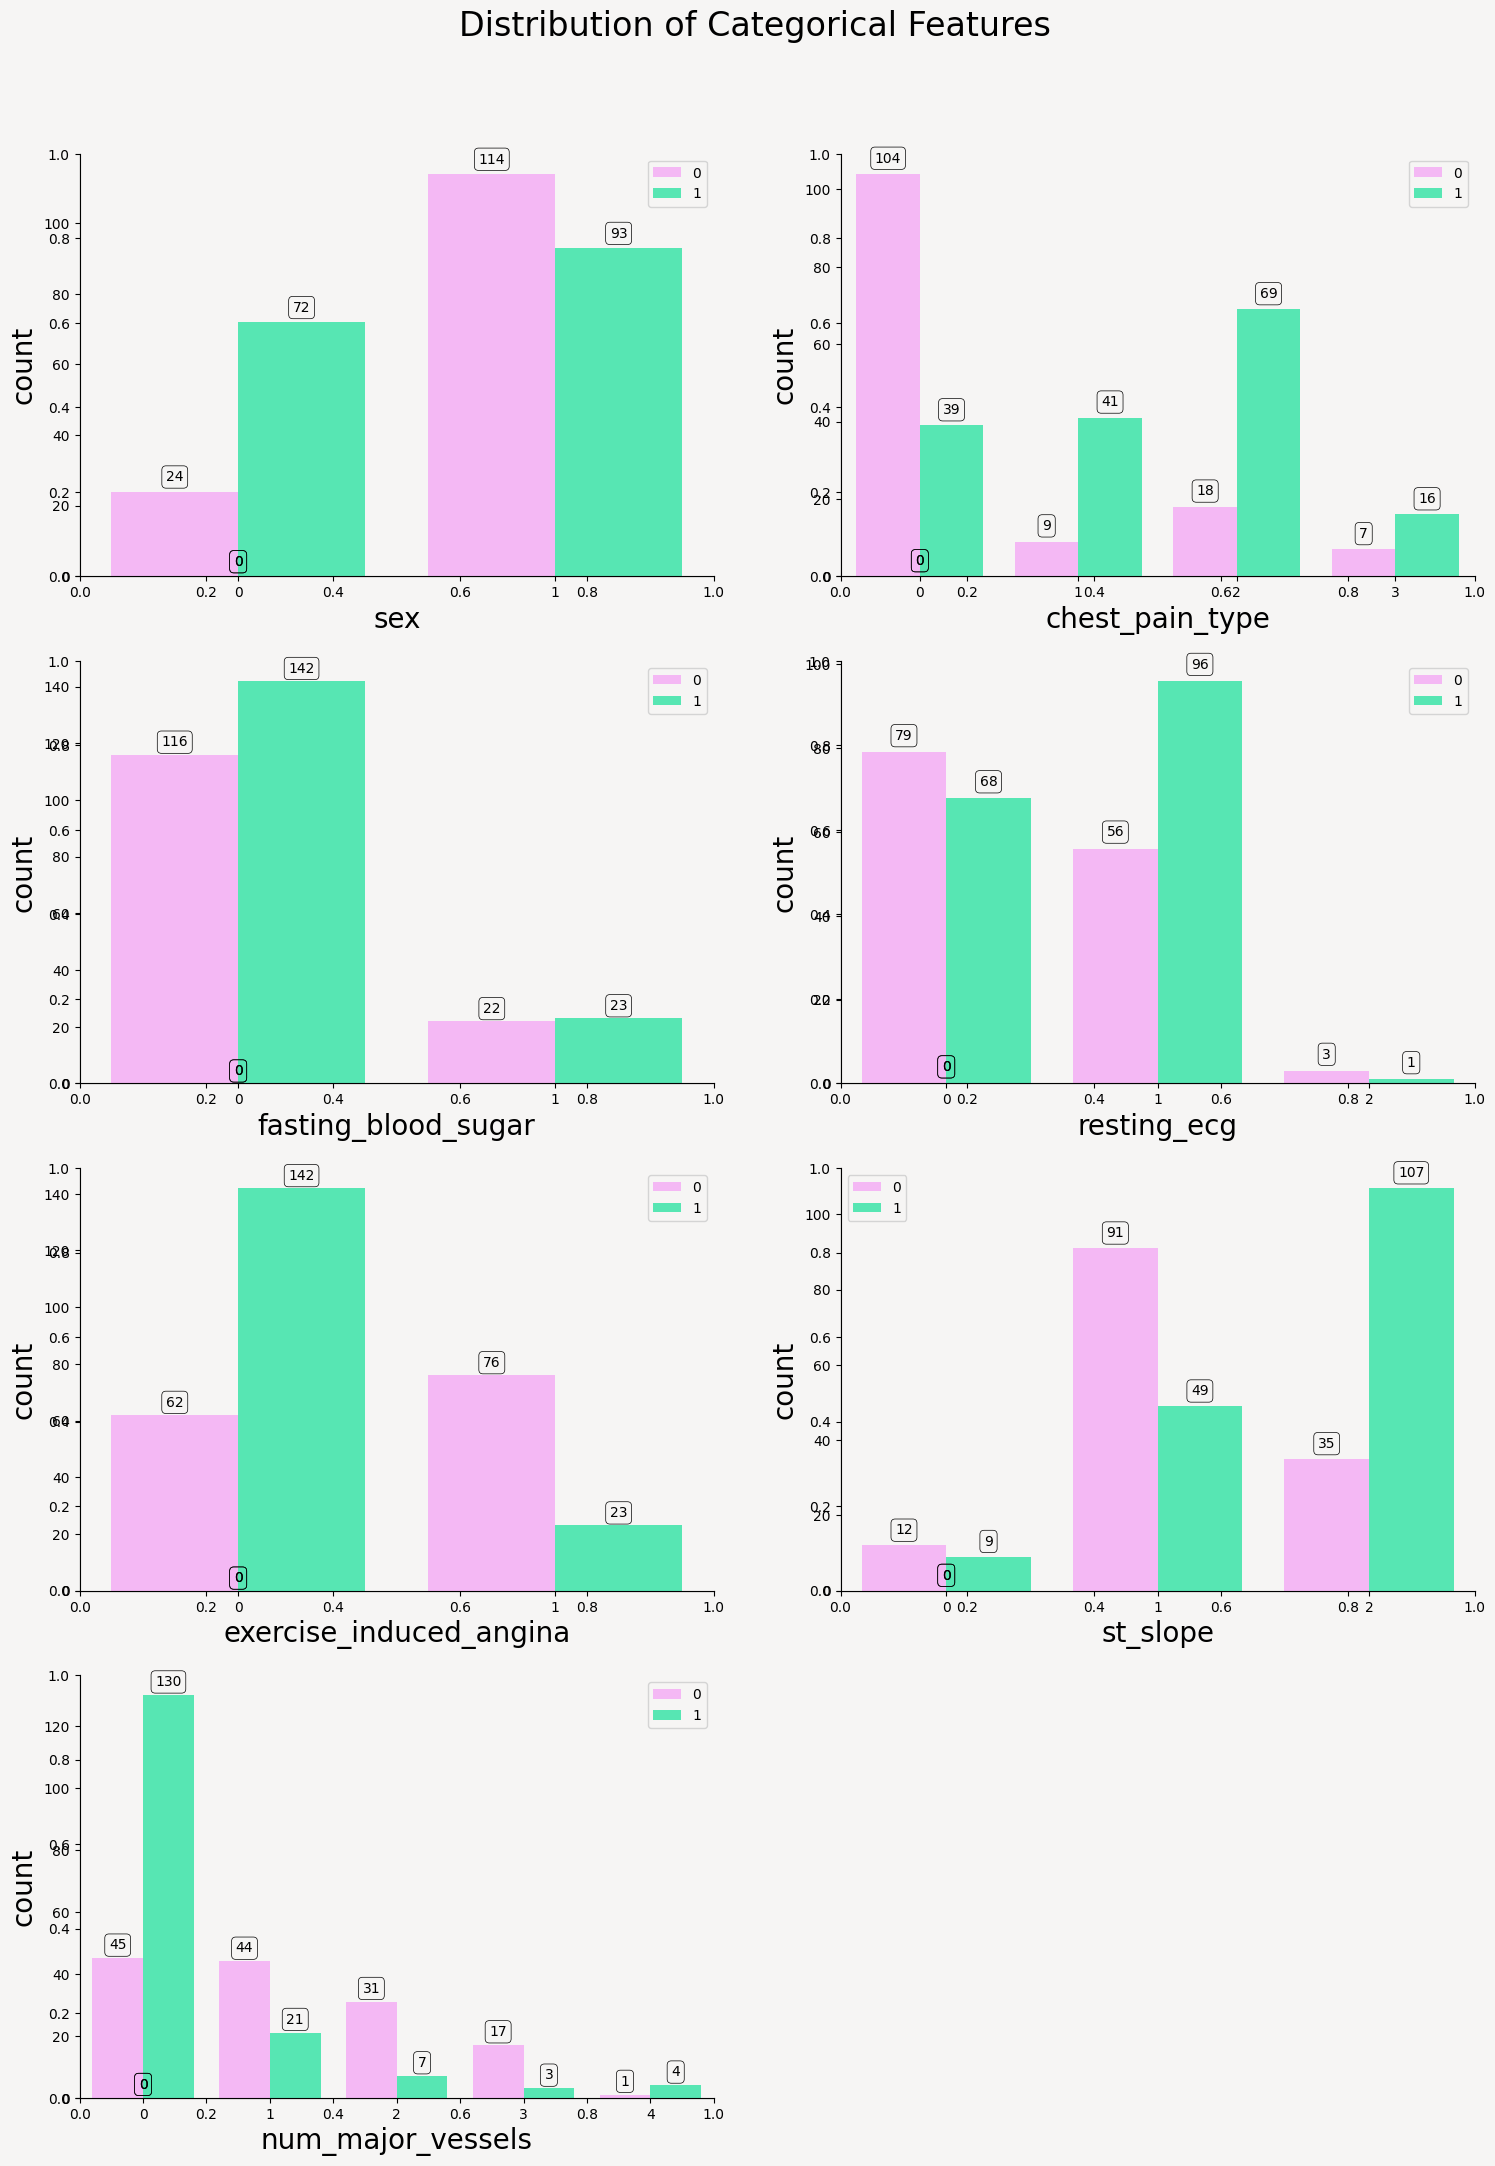

In [32]:
def count_plot(data, cat_feats):  
    mypal= ['#FC05FB', '#FEAEFE', '#FCD2FC','#F3FEFA', '#B4FFE4','#3FFEBA']
  
    L = len(cat_feats)
    ncol= 2
    nrow= int(np.ceil(L/ncol))
    remove_last= (nrow * ncol) - L

    fig, ax = plt.subplots(nrow, ncol,figsize=(18, 24), facecolor='#F6F5F4')    
    fig.subplots_adjust(top=0.92)
    ax.flat[-remove_last].set_visible(False)

    i = 1
    for col in cat_feats:
        plt.subplot(nrow, ncol, i, facecolor='#F6F5F4')
        ax = sns.countplot(data=data, x=col, hue="target", palette=mypal[1::4])
        ax.set_xlabel(col, fontsize=20)
        ax.set_ylabel("count", fontsize=20)
        sns.despine(right=True)
        sns.despine(offset=0, trim=False) 
        plt.legend(facecolor='#F6F5F4')
        
        for p in ax.patches:
            height = p.get_height()
            ax.text(p.get_x()+p.get_width()/2.,height + 3,'{:1.0f}'.format((height)),ha="center",
                  bbox=dict(facecolor='none', edgecolor='black', boxstyle='round', linewidth=0.5))
        
        i = i +1

    plt.suptitle('Distribution of Categorical Features' ,fontsize = 24)
    return 0

count_plot(data, categorical_features[0:-1]);

In [14]:
X = data[numeric_features + categorical_features]
y = data["target"]


In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [17]:

X_train.shape, X_test.shape

((242, 13), (61, 13))

In [18]:
scaler = StandardScaler()


In [19]:

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

In [22]:
X_train_scaled[numeric_features] = scaler.fit_transform(X_train_scaled[numeric_features])
X_test_scaled[numeric_features] = scaler.transform(X_test_scaled[numeric_features])

X_train_scaled.head()

,age,resting_blood_pressure,cholesterol,max_heart_rate_achieved,st_depression,sex,chest_pain_type,fasting_blood_sugar,resting_ecg,exercise_induced_angina,st_slope,num_major_vessels,thalassemia
19,1.610480,0.461840,-0.123235,0.039942,0.604853,0,3,0,1,0,2,2,2
247,1.282051,1.575595,0.023366,-1.373486,-0.890458,1,1,0,1,1,1,3,1
289,0.077810,-0.206413,-0.835301,-0.917541,0.770998,0,0,0,2,1,1,1,3
288,0.296763,-1.208792,1.887302,-0.324813,1.601727,1,0,0,1,1,1,1,3
60,1.829433,-1.208792,0.421285,-0.917541,-0.890458,0,2,1,0,0,2,1,2


In [39]:
rf_model=RandomForestClassifier(
    n_estimators=300,
    max_depth=5,
    min_samples_split=4,
    min_samples_leaf=2,
    random_state=42
)

In [40]:
rf_model.fit(X_train, y_train)

,n_estimators,300
,criterion,'gini'
,max_depth,5
,min_samples_split,4
,min_samples_leaf,2
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [41]:
print("Training Accuracy:", rf_model.score(X_train, y_train))
print("Test Accuracy:", rf_model.score(X_test, y_test))

Training Accuracy: 0.9380165289256198
Test Accuracy: 0.819672131147541


In [ ]:
def get_user_input():
    print("\nEnter patient details:")
    row={}
    for col in X.columns:
        row[col]=float(input(f"{col}:"))
        return pd.DataFrame([row],columns=X.columns)
    
user_input = get_user_input()
risk=rf_model.predict(user_input)[0][1]*100
print(f"\nPredicted risk of heart disease: {risk:.2f}%")

In [43]:
import joblib
joblib.dump(rf_model,"heart_model.joblib")
joblib.dump(scaler,"scaler.joblib")

['scaler.joblib']